In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%%capture
%pip install --no-deps bitsandbytes accelerate xformers peft trl triton cut_cross_entropy unsloth_zoo
%pip install sentencepiece protobuf datasets huggingface_hub hf_transfer nltk python-Levenshtein
%pip install --no-deps unsloth
%pip install -q albumentations opencv-python scikit-image
%pip install -q torch torchvision torchaudio
%pip install uncertainty-toolbox

In [3]:
import numpy as np
import torch
import cv2
from PIL import Image, ImageFilter, ImageEnhance
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
import re
import Levenshtein
import nltk
from nltk.translate.bleu_score import sentence_bleu
from datasets import load_dataset, Dataset
from transformers import TextStreamer
from trl import SFTTrainer, SFTConfig
from unsloth import FastVisionModel, is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator

nltk.download("punkt", quiet=True)

2025-07-30 23:59:10.002190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753919950.185742      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753919950.237232      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_36/1841279509.py:15: UserWarning: WARNING: Unsloth should be imported before trl, transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastVisionModel, is_bf16_supported


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


True

In [4]:
class SyntheticDataAugmentation:
    def __init__(self):
        self.use_simple_aug = True
        if not self.use_simple_aug:
            try:
                self.augmentation_pipeline = A.Compose([
                    A.OneOf([
                        A.GaussNoise(var_limit=(10.0, 30.0), p=0.3),
                        A.MultiplicativeNoise(multiplier=(0.95, 1.05), p=0.3),
                    ], p=0.4),
                    A.OneOf([
                        A.Blur(blur_limit=2, p=0.3),
                        A.MotionBlur(blur_limit=2, p=0.3),
                    ], p=0.3),
                    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
                    A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.05, rotate_limit=2, p=0.3),
                    A.Resize(height=224, width=224, p=1.0),
                ])
            except Exception as e:
                print(f"Albumentations setup failed, using simple augmentations: {e}")
                self.use_simple_aug = True

    def generate_synthetic_variations(self, image, latex_code, num_variants=3):
        variants = []
        for i in range(num_variants):
            try:
                if self.use_simple_aug:
                    augmented_image = self._simple_augment(image, i)
                else:
                    image_array = np.array(image)
                    augmented = self.augmentation_pipeline(image=image_array)
                    augmented_image = Image.fromarray(augmented['image'])
                varied_latex = self._vary_latex_code(latex_code)
                variants.append((augmented_image, varied_latex))
            except Exception as e:
                print(f"Warning: Augmentation {i} failed, using original: {e}")
                varied_latex = self._vary_latex_code(latex_code)
                variants.append((image, varied_latex))
        return variants

    def _simple_augment(self, image, variant_idx):
        img = image.copy()
        img = img.resize((224, 224), Image.Resampling.LANCZOS)
        if variant_idx == 0:
            img = img.rotate(random.uniform(-2, 2), fillcolor='white')
        elif variant_idx == 1:
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(random.uniform(0.9, 1.1))
        elif variant_idx == 2:
            enhancer = ImageEnhance.Contrast(img)
            img = enhancer.enhance(random.uniform(0.9, 1.1))
        if random.random() < 0.3:
            img_array = np.array(img)
            noise = np.random.normal(0, 5, img_array.shape).astype(np.uint8)
            img_array = np.clip(img_array + noise, 0, 255)
            img = Image.fromarray(img_array)
        return img

    def _vary_latex_code(self, latex_code):
        varied_code = latex_code.strip()
        varied_code = re.sub(r'\s+', ' ', varied_code)
        if random.random() < 0.3:
            varied_code = re.sub(r'([+\-=])', r' \1 ', varied_code)
            varied_code = re.sub(r'\s+', ' ', varied_code)
        if random.random() < 0.2 and '\\frac' in varied_code:
            varied_code = varied_code.replace('\\frac', '\\dfrac')
        return varied_code.strip()

In [5]:
def evaluate_model(model, tokenizer, dataset, max_samples=50):
    predictions = []
    targets = []
    instruction = "Write the LaTeX representation for this image."
    for i, sample in enumerate(dataset[:max_samples]):
        try:
            image = sample["image"]
            target_text = sample["text"]
            messages = [{
                "role": "user", "content": [
                    {"type": "text", "text": instruction},
                    {"type": "image", "image": image}
                ]
            }]
            input_text = tokenizer.apply_chat_template(
                messages, add_generation_prompt=True, tokenize=False
            )
            inputs = tokenizer(
                image, input_text,
                add_special_tokens=False,
                return_tensors="pt",
            ).to("cuda")
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=128,
                    pad_token_id=tokenizer.eos_token_id,
                )
            prediction = tokenizer.decode(
                outputs[0][inputs['input_ids'].shape[1]:],
                skip_special_tokens=True
            ).strip()
            predictions.append(prediction)
            targets.append(target_text)
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            predictions.append("")
            targets.append(target_text)

    # Calculate metrics
    exact_match = np.mean([p == t for p, t in zip(predictions, targets)])
    bleu_scores = []
    for p, t in zip(predictions, targets):
        try:
            bleu = sentence_bleu([t.split()], p.split())
        except:
            bleu = 0.0
        bleu_scores.append(bleu)
    avg_bleu = np.mean(bleu_scores) if bleu_scores else 0.0
    edit_dists = [Levenshtein.distance(p, t) for p, t in zip(predictions, targets)]
    avg_edit_dist = np.mean(edit_dists) if edit_dists else 0.0
    # Simple LaTeX compilation check (heuristic)
    compile_success = np.mean([1 if p.strip() and '{' in p and '}' in p else 0 for p in predictions])
    return {
        "exact_match": exact_match,
        "avg_bleu": avg_bleu,
        "avg_edit_distance": avg_edit_dist,
        "compile_success_rate": compile_success,
        "num_samples": len(predictions)
    }

In [6]:
def prepare_augmented_dataset(dataset, augmentator, augmentation_factor=2):
    augmented_samples = []
    for sample in dataset:
        image = sample["image"]
        text = sample["text"]
        # Original sample
        augmented_samples.append({"image": image, "text": text})
        # Augmented variants
        variants = augmentator.generate_synthetic_variations(image, text, augmentation_factor)
        for variant_img, variant_text in variants:
            augmented_samples.append({"image": variant_img, "text": variant_text})
    return Dataset.from_list(augmented_samples)

def convert_to_conversation(sample):
    instruction = "Write the LaTeX representation for this image."
    image = sample["image"]
    text = sample["text"]
    return {
        "messages": [
            {"role": "user", "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": image}
            ]},
            {"role": "assistant", "content": [
                {"type": "text", "text": text}
            ]}
        ]
    }

In [7]:
def main():
    print("=== LaTeX OCR with Synthetic Data Augmentation & Fine-tuning ===")
    
    # Initialize model
    model_name = "unsloth/Qwen2-VL-7B-Instruct"
    print("Loading model...")
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name,
        load_in_4bit=True,
        use_gradient_checkpointing="unsloth"
    )
    model = FastVisionModel.get_peft_model(
        model,
        finetune_vision_layers=True,
        finetune_language_layers=True,
        finetune_attention_modules=True,
        finetune_mlp_modules=True,
        r=16,
        lora_alpha=16,
        lora_dropout=0,
        bias="none",
        random_state=3407,
        use_rslora=False,
        loftq_config=None
    )
    FastVisionModel.for_inference(model)

    # Load dataset
    dataset = load_dataset("unsloth/Latex_OCR", split="train[:500]")  # Limit for demo
    split = dataset.train_test_split(test_size=0.2, seed=42)
    train_dataset = split["train"]
    eval_dataset = split["test"]

    # Synthetic augmentation
    augmentator = SyntheticDataAugmentation()
    print("Preparing synthetic-augmented training data...")
    augmented_train_data = prepare_augmented_dataset(train_dataset, augmentator, augmentation_factor=2)
    print(f"Original train samples: {len(train_dataset)}")
    print(f"Augmented train samples: {len(augmented_train_data)}")

    # Convert to conversation format
    train_conversations = [convert_to_conversation(s) for s in augmented_train_data]
    eval_conversations = [convert_to_conversation(s) for s in eval_dataset]

    # Before fine-tuning evaluation
    print("\n=== Before Fine-tuning Evaluation ===")
    eval_dataset = [dict(sample) for sample in split["test"]]
    baseline_metrics = evaluate_model(model, tokenizer, eval_dataset)
    for k, v in baseline_metrics.items():
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

    # Fine-tuning
    print("\n=== Fine-tuning with Synthetic Data ===")
    trainer = SFTTrainer(
        model=model,
        max_seq_length=2048,
        args=SFTConfig(
            per_device_train_batch_size=1,
            per_device_eval_batch_size=1,
            gradient_accumulation_steps=4,
            warmup_steps=5,
            max_steps=100,  # Short for demo
            learning_rate=2e-4,
            fp16=not is_bf16_supported(),
            bf16=is_bf16_supported(),
            logging_steps=10,
            save_steps=50,
            optim="adamw_8bit",
            weight_decay=0.01,
            lr_scheduler_type="linear",
            seed=3407,
            output_dir="outputs_synth_aug",
            report_to="none",
            dataset_text_field="",
            dataset_kwargs={"skip_prepare_dataset": True},
            remove_unused_columns=False,
            dataloader_num_workers=0,
        ),
        data_collator=UnslothVisionDataCollator(model, tokenizer),
        train_dataset=train_conversations,
        eval_dataset=eval_conversations,
    )
    trainer.train()

    # After fine-tuning evaluation
    print("\n=== After Fine-tuning Evaluation ===")
    FastVisionModel.for_inference(model)
    final_metrics = evaluate_model(model, tokenizer, eval_dataset)
    for k, v in final_metrics.items():
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

    # Improvement summary
    print("\n=== Improvement Summary ===")
    print("Metric\t\tBefore\tAfter\tChange")
    for metric in baseline_metrics:
        if isinstance(baseline_metrics[metric], float):
            delta = final_metrics[metric] - baseline_metrics[metric]
            pct = (delta / baseline_metrics[metric] * 100) if baseline_metrics[metric] != 0 else 0.0
            print(f"{metric}\t{baseline_metrics[metric]:.3f}\t{final_metrics[metric]:.3f}\t{pct:+.1f}%")

## Crack the main

In [8]:
print("=== LaTeX OCR with Synthetic Data Augmentation & Fine-tuning ===")
    
# Initialize model
model_name = "unsloth/Qwen2-VL-7B-Instruct"
print("Loading model...")
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-7B-Instruct",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth"
)
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers=True,
    finetune_language_layers=True,
    finetune_attention_modules=True,
    finetune_mlp_modules=True,
    r=16,
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    random_state=3407,
    use_rslora=False,
    loftq_config=None
)
FastVisionModel.for_inference(model)

=== LaTeX OCR with Synthetic Data Augmentation & Fine-tuning ===
Loading model...
==((====))==  Unsloth 2025.7.11: Fast Qwen2 patching. Transformers: 4.52.4.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/6.85G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json: 0.00B [00:00, ?B/s]

Unsloth: Making `model.base_model.model.model.visual` require gradients


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (model): Qwen2VLModel(
        (visual): Qwen2VisionTransformerPretrainedModel(
          (patch_embed): PatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-18): 19 x Qwen2VLVisionBlock(
              (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (attn): VisionSdpaAttention(
                (qkv): lora.Linear(
                  (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=16, bias=

In [9]:
# Load dataset
dataset = load_dataset("unsloth/Latex_OCR", split="train[:500]")  # Limit for demo
split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split["train"]
eval_dataset = split["test"]

README.md:   0%|          | 0.00/519 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/38.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/68686 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7632 [00:00<?, ? examples/s]

In [10]:
# Synthetic augmentation
augmentator = SyntheticDataAugmentation()
print("Preparing synthetic-augmented training data...")
augmented_train_data = prepare_augmented_dataset(train_dataset, augmentator, augmentation_factor=2)
print(f"Original train samples: {len(train_dataset)}")
print(f"Augmented train samples: {len(augmented_train_data)}")

Preparing synthetic-augmented training data...
Original train samples: 400
Augmented train samples: 1200


In [11]:
augmented_train_data

Dataset({
    features: ['image', 'text'],
    num_rows: 1200
})

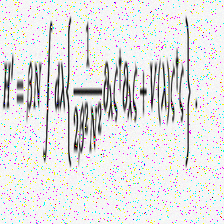

In [12]:
augmented_train_data[14]['image']

In [13]:
augmented_train_data[0]['text']

'J _ { \\alpha \\beta } \\equiv \\frac { 1 } { 4 } ( L _ { \\alpha } L _ { \\beta } + L _ { \\beta } L _ { \\alpha } ) .'

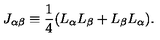

In [14]:
train_dataset[0]['image']

In [15]:
train_dataset[0]['text']

'J _ { \\alpha \\beta } \\equiv \\frac { 1 } { 4 } ( L _ { \\alpha } L _ { \\beta } + L _ { \\beta } L _ { \\alpha } ) .'

In [16]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import io

def generate_polynomial():
    """Generate a random polynomial equation in the form a_nx^n + ... + a_0."""
    # Choose degree (2, 3, 4)
    degree = random.randint(2, 4)
    
    # Generate coefficients (-9 to 9, avoiding zero for leading term)
    coefs = [random.randint(-9, 9) for _ in range(degree + 1)]
    while coefs[0] == 0:  # Leading coefficient cannot be zero
        coefs[0] = random.randint(-9, 9)
    
    # Construct LaTeX code
    terms = []
    for i in range(degree, -1, -1):
        c = coefs[degree - i]
        if c == 0:
            continue
        # Format term
        if i == 0:
            term = f"{c}"
        elif i == 1:
            term = f"{c}x"
        else:
            term = f"{c}x^{i}"
        # Handle sign and coefficient
        if c > 0 and i < degree:
            term = "+ " + term
        elif c < 0:
            term = "- " + str(abs(c)) + ("x" if i != 0 else "") + (f"^{i}" if i > 1 else "")
        # Remove space if degree 0
        if i == 0 and term[0] == " ":
            term = term[1:]
        terms.append(term)
    return " ".join(terms).replace("+ -", "- ")

def render_latex_to_image(latex_code):
    """Render LaTeX string as PNG using matplotlib."""
    fig = plt.figure(figsize=(4, 2))
    plt.text(0.5, 0.5, f'${latex_code}$', fontsize=24, ha='center', va='center')
    plt.axis('off')
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)
    buf.seek(0)
    image = Image.open(buf).convert("RGB")
    return image

def generate_synthetic_polynomial_dataset(num_samples=500):
    """Generate dataset of (image, polynomial LaTeX) pairs."""
    synthetic_poly = []
    for _ in range(num_samples):
        poly = generate_polynomial()
        image = render_latex_to_image(poly)
        synthetic_poly.append({'image': image, 'text': poly})
    return synthetic_poly

In [17]:
# Example usage
synthetic_poly = generate_synthetic_polynomial_dataset(50)

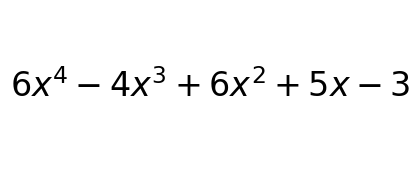

In [18]:
synthetic_poly[15]['image']

In [19]:
# Convert to conversation format
train_conversations = [convert_to_conversation(s) for s in augmented_train_data]
eval_conversations = [convert_to_conversation(s) for s in eval_dataset]

In [56]:
# Before fine-tuning evaluation
print("\n=== Before Fine-tuning Evaluation ===")
eval_dataset = [dict(sample) for sample in split["test"]]
baseline_metrics = evaluate_model(model, tokenizer, eval_dataset)
for k, v in baseline_metrics.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


=== Before Fine-tuning Evaluation ===
exact_match: 0.2000
avg_bleu: 0.7045
avg_edit_distance: 27.7400
compile_success_rate: 1.0000
num_samples: 50


In [21]:
import trl; print(trl.__version__)
import transformers; print(transformers.__version__)
import unsloth; print(unsloth.__version__)

0.20.0
4.52.4
2025.7.11


In [22]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

In [23]:
FastVisionModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (model): Qwen2VLModel(
        (visual): Qwen2VisionTransformerPretrainedModel(
          (patch_embed): PatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-18): 19 x Qwen2VLVisionBlock(
              (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (attn): VisionSdpaAttention(
                (qkv): lora.Linear(
                  (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=16, bias=

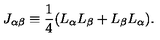

In [47]:
train_conversations[0]['messages'][0]['content'][1]['image']

In [48]:
for i, sample in enumerate(train_conversations):
    # Check top-level keys
    for key, value in sample.items():
        if value is None:
            print(f"WARNING: Found None at index {i}, top-level key '{key}'")
    # If 'messages' exists and is a list, check inner attributes
    if 'messages' in sample and isinstance(sample['messages'], list):
        for j, message in enumerate(sample['messages']):
            for key, value in message.items():
                if value is None:
                    print(f"WARNING: Found None at index {i}, message {j}, key '{key}'")
            # If 'content' is a list (common in VLMs), check inside too
            if 'content' in message and isinstance(message['content'], list):
                for k, item in enumerate(message['content']):
                    if isinstance(item, dict):
                        for key, value in item.items():
                            if value is None:
                                print(f"WARNING: Found None at index {i}, message {j}, content item {k}, key '{key}'")


In [52]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    max_seq_length=2048,
    data_collator=UnslothVisionDataCollator(model, tokenizer),
    train_dataset=train_conversations,
    eval_dataset=eval_conversations,  # Limit eval dataset for faster training
    args=SFTConfig(
        per_device_train_batch_size=2,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=100,
        learning_rate=2e-4,
        fp16=not is_bf16_supported(),
        bf16=is_bf16_supported(),
        logging_steps=5,
        eval_steps=25,
        eval_strategy="steps",
        save_steps=50,
        save_total_limit=2,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="none",
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs={"skip_prepare_dataset": True},
        dataset_num_proc=4,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        dataloader_num_workers=0,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [53]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,200 | Num Epochs = 2 | Total steps = 100
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 50,855,936 of 8,342,231,552 (0.61% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
25,0.164600,0.118502
50,0.156200,0.114291
75,0.120700,0.108218
100,0.136300,0.108913


Unsloth: Not an error, but Qwen2VLForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


TrainOutput(global_step=100, training_loss=0.243515767455101, metrics={'train_runtime': 1479.6935, 'train_samples_per_second': 1.081, 'train_steps_per_second': 0.068, 'total_flos': 1.455338164482048e+16, 'train_loss': 0.243515767455101})

In [55]:
eval_dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 100
})

In [54]:
# After fine-tuning evaluation
print("\n=== After Fine-tuning Evaluation ===")
FastVisionModel.for_inference(model)
eval_dataset = [dict(sample) for sample in split["test"]]
final_metrics = evaluate_model(model, tokenizer, eval_dataset)
for k, v in final_metrics.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


=== After Fine-tuning Evaluation ===
Error processing sample 0: string indices must be integers, not 'str'


UnboundLocalError: cannot access local variable 'target_text' where it is not associated with a value

In [ ]:
# if __name__ == "__main__":
#     main()